# Extremum Seeking Control (ESC)

El Extremum Seeking Control  es un método de control adaptativo que busca en tiempo real el valor óptimo (mínimo o máximo) de una función objetivo sin necesidad de conocer explícitamente el modelo del sistema.La idea principal es introducir una pequeña perturbación sinusoidal en el parámetro de control, observar cómo responde el sistema y ajustar dicho parámetro en la dirección que mejora el desempeño.


## Funcionamiento paso a paso

1. **Modulación del parámetro**  
   El controlador añade una perturbación sinusoidal al parámetro de control:  

   $$u(t) = \hat{u}(t) + a \cdot \sin(\omega t)$$

   donde:  
   - $\hat{u}(t)$ = valor estimado del parámetro  
   - $a$ = amplitud de perturbación  
   - $\omega$ = frecuencia de perturbación

   

2. **Respuesta del sistema**  
   El sistema produce una salida $y(t)$ que depende de este parámetro perturbado.  
   Si la función objetivo tiene un extremo, la salida se verá afectada de manera proporcional a la cercanía al óptimo.

3. **Demodulación**  
   Para extraer información sobre la dirección del gradiente, la salida se multiplica por la misma señal sinusoidal:  
   
   La salida del sistema $y(t)$ se multiplica por la señal de perturbación:

   $$s(t) = y(t) \cdot \sin(\omega t)$$


4. **Filtrado paso bajo**  
   El producto anterior contiene componentes de alta frecuencia que se eliminan con un filtro paso bajo, quedando una señal proporcional al gradiente:  

   $$\hat{g}(t) \approx LPF(s(t))$$
   

5. **Actualización del parámetro**  
   Finalmente, el parámetro estimado se ajusta en la dirección del gradiente:

   $$\dot{\hat{u}}(t) = k \cdot \hat{g}(t)$$
   donde $k$ es la ganancia de adaptación que controla la velocidad de convergencia.







## Implementacion del controlador

 Para el caso del extremum seeking control, debido a la complejidad se implementara la estrategia de control de temperatura de un solo salón. En este caso se asume
 que se tiene un quinto salón separado de los demás, con Tref5 
= 22C y C5 = C el cuál solo está en
 contacto con el ambiente (Ta(t) = 8C). Las dinámicas asociadas a la temperatura de un salón quedarían
 reducidas a la siguiente expresión:



$$
C \cdot T(t) \;=\; u_{5}(t) \;+\; \big( Ta(t) - T_{5}(t) \big)
$$













###  Parámetros del sistema
El modelo describe cómo evoluciona la temperatura del salón en función de la potencia aplicada y las pérdidas al ambiente. La ecuación diferencial es:

$$
\frac{dT}{dt} \;=\; \frac{u}{C} \;+\; \frac{\alpha}{C}\,(T_a - T)
$$

donde:

- $C$: capacitancia térmica [J/°C]  
- $\alpha$: conductancia al ambiente [W/°C]  
- $T_a$: temperatura ambiente [°C]  
- $T_{\text{ref}}$: referencia [°C]  
- $T_0$: condición inicial [°C]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros del sistema
C = 74760
alpha = 123.6
Ta = 8.0
Tref = 22.0
T0 = 8.0
dt = 1.0
t_final = 3600
t = np.arange(0, t_final + dt, dt)

## 2. Límites del actuador
Se define el siguiente rango para la potencia maxima que puede aplicar el actuador
- $u_{\min} = 0$  
- $u_{\max} = 2500$

In [2]:
# Límites del actuador
u_min = 0.0
u_max = 2500.0

### Flujo de simulación del controlador ESC

El código simula cómo un **controlador ESC ajusta automáticamente la potencia de calefacción** para mantener la temperatura cerca de un valor deseado.  
Utiliza un **ruido sinusoidal** para explorar el sistema, un **filtro pasa bajas** para extraer la información útil, y una **ley de adaptación** para modificar el sesgo de control.

1. **Inicialización de variables y condiciones iniciales**  
   - Se crean vectores para registrar temperatura, entrada total, error, señal demodulada y filtrada, y sesgo del controlador.  
   - La temperatura arranca en `T0` = 8 °C.  
   - El sesgo inicial de potencia se calcula como proporcional a la diferencia entre la temperatura de referencia y ambiente.

2. **Bucle de simulación**  

   Durante cada iteración de la simulación se genera una señal sinusoidal que se suma al sesgo para obtener la entrada del controlador, la cual se limita entre los valores mínimos y máximos permitidos. Con esta entrada se actualiza la dinamica de temperatura por medio de una ecuación diferencial simplificada y se calcula el error respecto a la referencia. 
   
   Posteriormente el error se multiplica por la señal sinusoidal y se pasa por un filtro pasa bajas (con coeficiente `beta`) para suavizar la señal. Finalmente, el sesgo del controlador se ajusta restando una ganancia proporcional (`k`) a la señal filtrada, esto permite que el sistema se acerque al valor de referencia definido


3. **Resultados**  
   La función devuelve como resultado las siguientes variables de la simulacion realizada:
   - T: comportamiento de la temperatura  
   - u_total: potencia aplicada   
   - e: error respecto a la temperatura de referencia
   - demod_raw: señal demodulada sin filtrar  
   - demod_lp: señal demodulada filtrada  
   - u_bias: evolución del sesgo del controlador






In [3]:
# Función de simulación ESC con registro de señales internas
def simular_ESC(A, omega, k, beta):
    T = np.zeros_like(t)
    u_total = np.zeros_like(t)
    e = np.zeros_like(t)
    demod_raw = np.zeros_like(t)
    demod_lp = np.zeros_like(t)
    u_bias = np.zeros_like(t)

    T[0] = T0
    u_esc = alpha * (Tref - Ta)   
    lp = 0.0

    for i in range(1, len(t)):
        sin_signal = A * np.sin(omega * t[i-1])
        u = np.clip(u_esc + sin_signal, u_min, u_max)

        dTdt = (u / C) + (alpha / C) * (Ta - T[i-1])
        T[i] = T[i-1] + dTdt * dt
        u_total[i] = u

        e[i] = T[i-1] - Tref
        demod_raw[i] = e[i] * np.sin(omega * t[i-1])
        lp = beta * lp + (1 - beta) * demod_raw[i]
        demod_lp[i] = lp

        u_esc -= k * lp
        u_bias[i] = u_esc

    return T, u_total, e, demod_raw, demod_lp, u_bias
   

## 4. Configuraciones de prueba
Para una primera prueba del controlador se realizaron simulaciones con las siguientes combinaciones de parametros buscando identificar una varidad en el comportamiento de la estrategia implementada:

1. A=50, k=0.005, ω=2π/120, β=0.99
2. A=400, k=0.02, ω=2π/120, β=0.9
3. A=200, k=0.1, ω=2π/120, β=0.99

In [4]:
configs = [
    {"A": 50, "omega": 2*np.pi/120.0, "k": 0.005, "beta": 0.99},   
    {"A": 400, "omega": 2*np.pi/120.0, "k": 0.02, "beta": 0.9},    
    {"A": 200, "omega": 2*np.pi/120.0, "k": 0.1, "beta": 0.99}     
]


## 5. Simulación del controlador

Se realiza la simulacion para las 3 combianciones de parametros y los resultados son almacenados en la variable `results` para su posterior analisis

In [5]:
results = []
for cfg in configs:
    results.append(simular_ESC(cfg["A"], cfg["omega"], cfg["k"], cfg["beta"]))

## 6. Metricas de evaluacion y visualizacion de resultados.


En esta seccion se organizaran los resultados obtenidos en una tabla junto con los parametros de ejecucion para su posterior analisis junto con la visualizacion de las estrategias implementadas. En primer, lugar se definen los siguientes parametros para el analisis:


- BANDA = 0.5: tolerancia (±0.5 °C) alrededor de la referencia para considerar el sistema “estable”.
- W_FINAL = 500: ventana final de tiempo (500 s) usada para calcular métricas de estado estacionario.


In [6]:

BANDA = 0.5       
W_FINAL = 500     

**Función `tiempo_establecimiento`**:
Esta funcion calcula el instante en que la temperatura entra dentro de la banda de tolerancia y se mantiene allí hasta el final.
   

In [7]:
def tiempo_establecimiento(t, T, Tref, banda):   
    err = np.abs(T - Tref)
    within = err <= banda
    for i in range(len(T)):
        if within[i] and np.all(within[i:]):
            return t[i]
    return np.nan

**Función `metrics_for_run_min`**: Calucla las siguineste metricas de evaluacion de las estrategias de control.
   
 - RMSE_T: error cuadrático medio respecto a la referencia.
 - SS_error_mean: error promedio en la ventana final.
 - Tiempo_establecimiento: tiempo para entrar en la banda de tolerancia.
 - Overshoot_max: máximo sobrepaso respecto a la referencia.
 - Osc_final: amplitud de oscilación en la ventana final.
 - Energy_Ws: energía total aplicada .
 - u_peak: valor máximo de la señal de control.
     



In [8]:
def metrics_for_run_min(t, T, u, demod_lp, Tref, u_min, u_max, dt, banda=BANDA, w_final=W_FINAL):
    # índices de la ventana final
    w = int(w_final / dt)
    w = max(1, min(w, len(t)))
    T_end = T[-w:]
    rmse = np.sqrt(np.mean((T - Tref)**2))
    ss_error_mean = np.mean(T_end - Tref)
    ts = tiempo_establecimiento(t, T, Tref, banda)
    overshoot = max(0.0, np.max(T - Tref))
    osc_final = np.max(T_end) - np.min(T_end)
    energy = np.sum(u) * dt
    u_peak = np.max(u)

    return {
        "RMSE_T": rmse,
        f"SS_error_mean": ss_error_mean,
        f"Tiempo_establecimiento_±{banda}°C": ts,
        "Overshoot_max": overshoot,
        f"Osc_final": osc_final,
        "Energy_Ws": energy,
        "u_peak": u_peak,
    }

Posteriormente se realiza la construcción de la tabla de resultados con la simulacion de todas las combinaciones de parametros, para cada una de ellas se ejecutan las funciones descritas anteriormente y se calculan las metricas de evaluacion, las cuales se guardan en un datagrame junto con los parametros de ejecucion (`A`, `k`, `omega`, `beta`)

In [9]:
rows = []
for cfg, res in zip(configs, results):
    T, u_total, e, demod_raw, demod_lp, u_bias = res
    m = metrics_for_run_min(t, T, u_total, demod_lp,
                            Tref=Tref, u_min=u_min, u_max=u_max, dt=dt,
                            banda=BANDA, w_final=W_FINAL)
    m["A"] = cfg["A"]; m["k"] = cfg["k"]; m["omega"] = cfg["omega"]; m["beta"] = cfg["beta"]
    rows.append(m)

df_result = pd.DataFrame(rows)
param_cols = ["A", "k", "omega", "beta"]
metric_cols = [c for c in df_result.columns if c not in param_cols]
df_result = df_result[param_cols + metric_cols]



### Visualización y analisis

Para el analisis de resultados se presentan las siguientes graficas de las simulaciones:

1. Temperatura vs tiempo.
2. Señal de control total.
3. Error.
4. Demodulación cruda.
5. Demodulación filtrada.
6. Sesgo adaptativo.

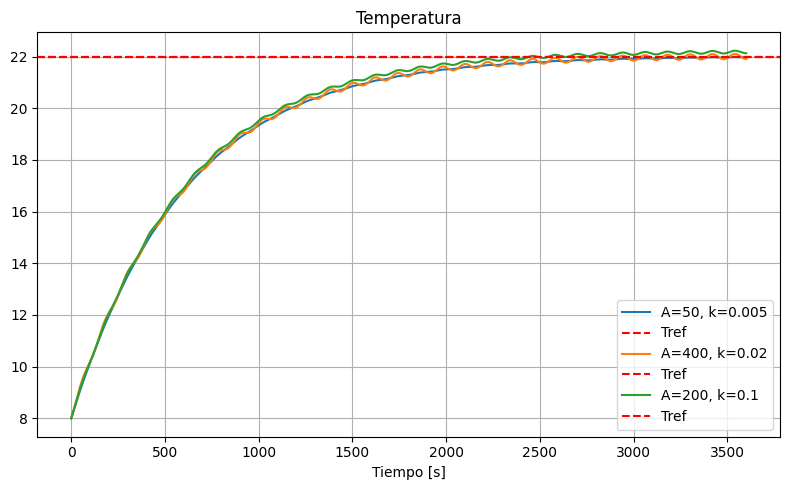

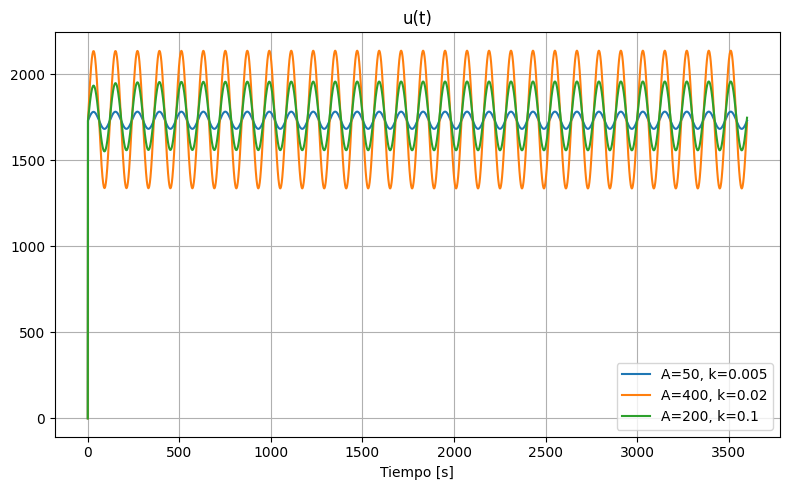

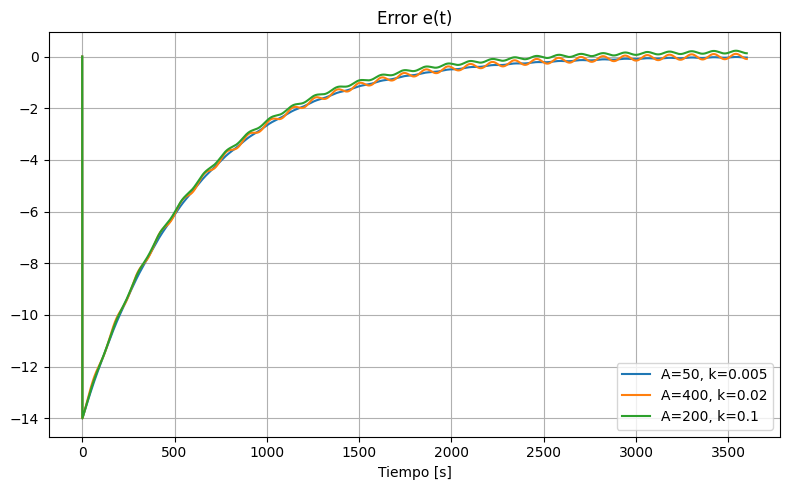

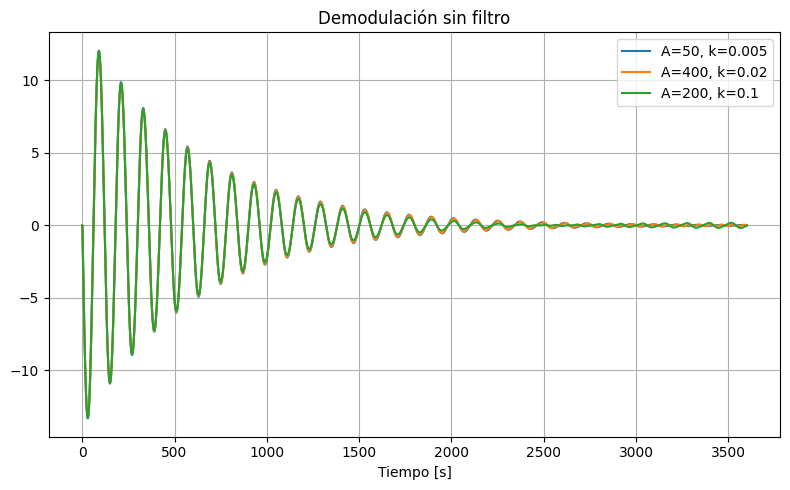

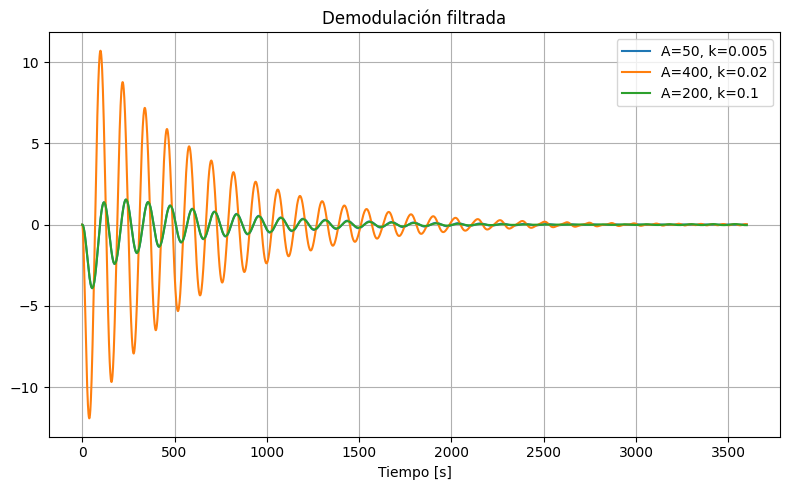

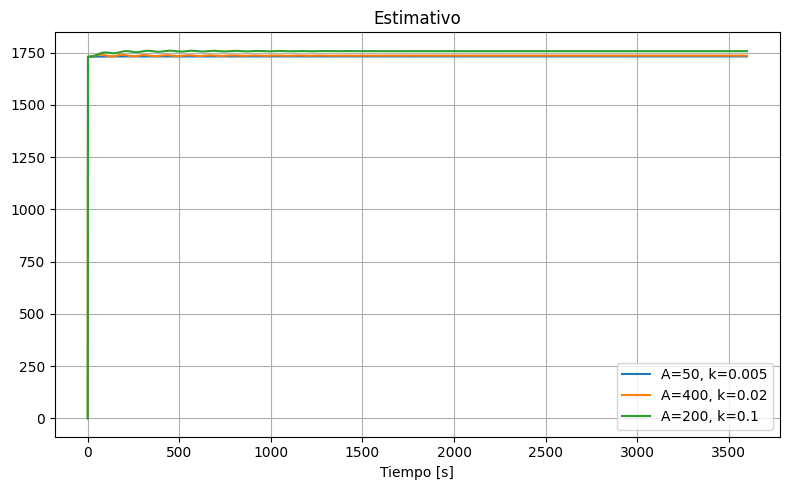

In [10]:
titles = ["Temperatura", "u(t)", "Error e(t)", "Demodulación sin filtro", "Demodulación filtrada", "Estimativo"]
# Crear una figura por tipo de señal, con las 3 curvas juntas
for i, title in enumerate(titles):
    plt.figure(figsize=(8,5))
    for idx, cfg in enumerate(configs):
        data = results[idx][i]
        label = f"A={cfg['A']}, k={cfg['k']}"
        plt.plot(t, data, label=label)
        if i == 0:  
            plt.axhline(Tref, color='r', linestyle='--', label="Tref")
    plt.title(title)
    plt.xlabel("Tiempo [s]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
df_result.style.set_caption("Métricas ESC (combinaciones)")

,A,k,omega,beta,RMSE_T,SS_error_mean,Tiempo_establecimiento_±0.5°C,Overshoot_max,Osc_final,Energy_Ws,u_peak
0,50,0.005000,0.052360,0.990000,4.052539,-0.045969,1988.000000,0.000000,0.066042,6234107.625821,1781.733219
1,400,0.020000,0.052360,0.900000,4.017995,-0.016632,2054.000000,0.105277,0.244455,6248487.205878,2135.703516
2,200,0.100000,0.052360,0.990000,3.995066,0.156349,1823.000000,0.225735,0.143047,6322559.552286,1957.053582



Al comparar las tres simulaciones se observa que todas presentan un error promedio similar ( 4 °C), lo que indica que la precisión global del controlador no cambia drásticamente entre configuraciones. Sin embargo, las diferencias aparecen en la dinámica y la potencia aplicada. El primer caso resulta ser el más estable de los 3, ya que no presenta overshoot y las oscilaciones finales son de una baja amplitud, aunque se debe tener en cuenta que esto se consigue en un tiempo de establecimiento mayor ( 1988 s). El segundo caso mantiene un error estacionario cercano a cero, pero muestra el tiempo de establecimiento más lento (2054 s) y mayores oscilaciones finales, además de requerir una mayor potencia por parte del actuador (u_peak ≈2136 W). 

Por otro lado, el tercer caso ofrece el mejor equilibiro entre las metricas de evaluación: alcanza el tiempo de establecimiento más rápido (1823 s) y mantiene un RMSE similar, aunque introduce un pequeño overshoot (0.22 °C) y un error estacionario positivo (0.16 °C). En conclusión, si se prioriza la estabilidad y suavidad de la respuesta del controlador, el primer caso es recomendable, si se busca rapidez de convergencia, el tercer caso es más eficiente, mientras que el segundo caso es el que presenta mas complicaciones con mayores oscilaciones y esfuerzo del controlador.


## 8. Alternativa ESC con ganancia adaptativa

En las simulaciones realizadas anteriormente implementando ESC tradicional, la ganancia \(k\) se manejo como constante para cada combiancion. En los resultados obtenidos se pudo observar que en todos se presentaron oscilaciones y asi fueran de una baja amplitud en este contexto se busca entre otras cosas un comportamiento estable y suave ademas una convergencia rapida. Para mejorar el desempeño, se propone usar una **ganancia adaptativa** que dependa de la magnitud del gradiente estimado $ \hat{g}(t) $.


La idea es que al inicio, cuando el gradiente es grande, la ganancia sea pequeña para evitar oscilaciones y a medida que el sistema se acerca al óptimo y el gradiente disminuye, la ganancia aumenta permitiendo una mayor precisión.


### Fórmula de la ganancia adaptativa

La ganancia se define como:

$$
k(t) = \frac{k_{max}}{1 + \gamma \cdot |\hat{g}(t)|}
$$

donde:
- $k_{max}$: ganancia máxima (cuando el gradiente es pequeño).  
- $\gamma$: factor de ajuste que controla cuánto se reduce la ganancia cuando el gradiente es grande.  
- $\lvert \hat{g}(t) \rvert$: magnitud del gradiente estimado.



La regla de actualización del sesgo del control se convierte en:

$$
\dot{\hat{u}}(t) = k(t) \cdot \hat{g}(t)
$$


A continuacion define la funcion para ejecutar el bucle de simulacion con la modificacón descrita anteriomente.

In [12]:
def simular_ESC_adaptativo(A, omega, k_max, beta, gamma):
    T = np.zeros_like(t)
    u_total = np.zeros_like(t)
    e = np.zeros_like(t)
    demod_raw = np.zeros_like(t)
    demod_lp = np.zeros_like(t)
    u_bias = np.zeros_like(t)
    k_values = np.zeros_like(t)  # registrar la ganancia adaptativa

    T[0] = T0
    u_esc = alpha * (Tref - Ta)   
    lp = 0.0

    for i in range(1, len(t)):
        sin_signal = A * np.sin(omega * t[i-1])
        u = np.clip(u_esc + sin_signal, u_min, u_max)

        dTdt = (u / C) + (alpha / C) * (Ta - T[i-1])
        T[i] = T[i-1] + dTdt * dt
        u_total[i] = u

        e[i] = T[i-1] - Tref
        demod_raw[i] = e[i] * np.sin(omega * t[i-1])
        lp = beta * lp + (1 - beta) * demod_raw[i]
        demod_lp[i] = lp

        # Ganancia adaptativa
        k_t = k_max / (1 + gamma * abs(lp))
        k_values[i] = k_t

        # Actualización del sesgo con ganancia adaptativa
        u_esc -= k_t * lp
        u_bias[i] = u_esc

    return T, u_total, e, demod_raw, demod_lp, u_bias, k_values


Posteriormente se realiza la simulacion con los mismos parametros (aparte de la ganancia) del caso 1, el cual resultdo ser el mas estable de los 3 para poder observar como mejora el comportamiento al implementar tambien una ganancia adaptativa.

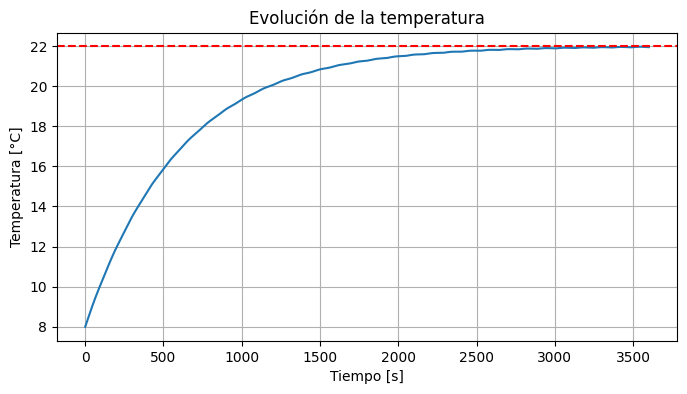

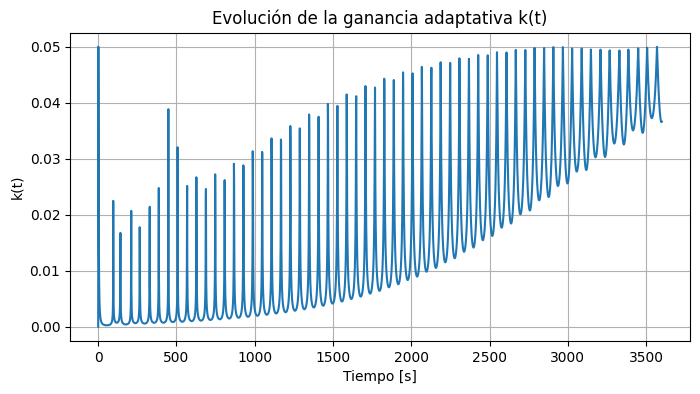

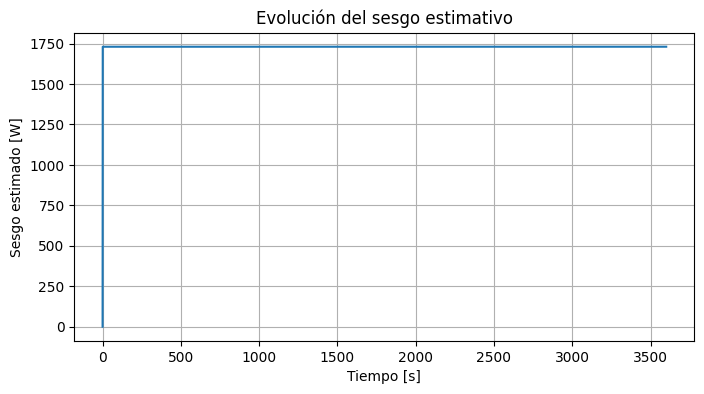

In [13]:

A = 50
omega = 2*np.pi/120.0
k_max = 0.05
beta = 0.99
gamma = 50.0

T, u_total, e, demod_raw, demod_lp, u_bias, k_values = simular_ESC_adaptativo(A, omega, k_max, beta, gamma)




# Temperatura
plt.figure(figsize=(8,4))
plt.plot(t, T)
plt.axhline(Tref, color='r', linestyle='--')
plt.title("Evolución de la temperatura")
plt.xlabel("Tiempo [s]")
plt.ylabel("Temperatura [°C]")
plt.grid(True)
plt.show()

# Evolución de la ganancia adaptativa
plt.figure(figsize=(8,4))
plt.plot(t, k_values)
plt.title("Evolución de la ganancia adaptativa k(t)")
plt.xlabel("Tiempo [s]")
plt.ylabel("k(t)")
plt.grid(True)
plt.show()

# Sesgo estimativo
plt.figure(figsize=(8,4))
plt.plot(t, u_bias)
plt.title("Evolución del sesgo estimativo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Sesgo estimado [W]")
plt.grid(True)
plt.show()





En los resultados obenidos del controlador con ganancia adaptativa se puede observar como la tmperatura se comporta de una manera mas estable y suave a comparacion de las implementaciones realizadas con gananzia fija, en la grafica se puede observar que se logra reducir las oscilación en la respuesta en un tiempo de establecimiento similar. Por otro lado tambien es posible observar como la busqueda del estimativo tambien es mucho mas estable durante la simulación a diferencia de las combinaciones utilizadas en primer lugar, se puede resaltar una mejor precicison cuando el estimativo se encuentea cerca del optimo. Por ultimo, en la grafica que muestra la evolución de la ganacia se logra detallar con claridad el ajuste implementado y como conforme la temperatura se va acercando a la referencia el rango de k tambien se va acotando.

En conclusion, el ajuste de ganancia adaptativa implementado al controlador ESC funciono correctamente y es una buena alternativa si lo que se buscra es obtener una respuesta suave y estable por parte del controlador como ocurre en este contexto, donde al tratarse de un control de temperatura se espera que la estrategia implementada ademas de alcanzar la referencia en poco tiempo y sin error estacionario tambien se busca que no se presenten sobrepicos ni oscilaciones en la temperatura.